# Inverted File Test

This notebook has for purpose the benchmarking of an InvertedFile. Below, we will try to evaluate the efficiency of our system by measuring :  
  
priority 1 :
- the space taken on disc by an inverted file of an arbitrary size
- the time taken on disc to read a posting list  

priority 2 :
- the time taken to write on disc an inverted file of an arbitrary size 
- the time taken to merge on disc two inverted files of an arbitrary size
  
Constants :  
  
LATIMES_PATH : string, the path to the xml files to read  

In [1]:
import glob
import time
import random

import numpy as np
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ParseError
import matplotlib.pyplot as plt

from pyscripts.inverted_file import InvertedFile
from pyscripts.formatted_document import FormattedDocument
from pyscripts.naive_disc_interfacer import NaiveDiscInterfacer as ndi
from pyscripts.smart_disc_interfacer import SmartDiscInterfacer as sdi

LATIMES_PATH = '../latimes'

## Define utilities functions

In [2]:
def read_files(paths, n=-1):
    """
    Read n files from a list of paths and convert them as xml trees. A root node <RAC> is added to every file to avoid some
    ParseError
    parameters :
        - paths : enumeration of strings, a list of absolute paths where datas have to be read (datas must be xml files)
        - n : number of files needed to be read, if -1, every possible files will be read
    return :
        - a list of len=(min(n, number of files) if n != -1, else number of files) of xml trees representations
          of the documents
    """
    output = []
    for path in paths:
        try:
            txt = open(path, 'r').read()
            output.append(ET.fromstring('<RAC>'+txt+'</RAC>'))
            n -= 1
            print('Successfully parsed document <{}>'.format(path))
        except ParseError as e:
            print('Can\'t parse document <{}>. Doesn\'t matter, skip'.format(path))
        except IsADirectoryError:
            print('Can\'t parse directory <{}>. Doesn\'t matter, skip'.format(path))
        if n == 0:
            return output
    return output

def score(token, document):
    """
    Basic score function to make the inverted files work.
    Doesn't have any computational interest
    """
    paragraph_tokens = document['text']
    paragraph_tokens.append(document['title'])
    token_count = 0
    for paragraph in paragraph_tokens:
        for word in paragraph:
            if word == token:
                token_count += 1
    return token_count

## Define Benchmarking functions

In [3]:
def space_on_disc(number_of_document, interfacer):
    """
    Simulate the evolution of the space taken on disc in function of the number of
    document we put in an inverted file.
    The simulation takes place only in the size order of small datasets, when all the inverted file can fit in memory
    :param number_of_document : integer, how many documents should be saved on disc
    return : integer, the size of the file (in bytes) if we would save it
    """
    inverted_file = InvertedFile(score, interfacer)
    files = glob.iglob(LATIMES_PATH + '/*')
    xml_files = read_files(files, number_of_document)
    for f in xml_files:
        document = FormattedDocument(f)
        for article in document.matches:
            inverted_file.add_document(article)
            
    return len(inverted_file.get_object_as_array())
    
def time_to_read_posting_list(number_of_document, number_of_pl_to_read, interfacer):
    """
    Simulate the reading of a posting list, in function of the approximate size of an inverted file,
    expressed in number of document injected in.
    The simulation takes place only in the size order of small datasets, when all the inverted file can fit in memory
    For better precision, the posting lists are read in random order, to not false the time it takes to physically replaces 
    the lecture head.
    :param number_of_document : integer, how many documents should be saved on disc
    :param number_of_pl_to_read : integer, how many posting lists should be read to make the mean 
                                  (to improve computationnal speed)
    return : integer, the mean time it takes to read a posting list of this inverted file
    """
    
    # preparing the inverted file
    inverted_file = InvertedFile(score, interfacer)
    files = glob.iglob(LATIMES_PATH + '/*')
    xml_files = read_files(files, number_of_document)
    for f in xml_files:
        document = FormattedDocument(f)
        for article in document.matches:
            inverted_file.add_document(article)
            
    # saving inverted file on disc
    inverted_file.save('tps.sav')
    keys = list(inverted_file.map.keys())
    random.shuffle(keys)
    
    # reading keys
    values = []
    inverted_file2 = InvertedFile(score, interfacer)
    for key in keys[:number_of_pl_to_read]:
        t_begin = time.clock()
        inverted_file2.read_posting_lists([key], 'tps.sav')
        values.append(time.clock() - t_begin)
    return np.asarray(values).mean()
    

## Define General Benchmark parameters

In [4]:
# how many files are injected in
number_of_files = len(list(glob.iglob(LATIMES_PATH + '/*')))
number_of_docs = np.asarray([1, 3, 6, 10])

## Space on disc benchmarking

In [5]:
space_taken_naive = []
space_taken_smart = []
for n in number_of_docs:
    cur_space= space_on_disc(n, ndi)
    cur_space_smart = space_on_disc(n, sdi)
    space_taken_naive.append(cur_space)
    space_taken_smart.append(cur_space_smart)
    print(cur_space)
    print(cur_space_smart)

Successfully parsed document <../latimes/la123189>
[nltk_data] Downloading package punkt to /home/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Successfully parsed document <../latimes/la123189>
[nltk_data] Downloading package punkt to /home/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
841780
571923
Successfully parsed document <../latimes/la123189>
Successfully parsed document <../latimes/la102989>
Successfully parsed document <../latimes/la081889>
[nltk_data] Downloading package punkt to /home/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Successfully parsed document <../latimes/la123189>
Successfully parsed document <../latimes/la102989>
Successfully parsed document 

## Observation

Between one and 10 documents saved, the weight of a document is approximately halved. Then it remains stable. The growth of the file size is linear in function of the number of documents  

display of the absolute space taken by the inverted file
in function of the number of documents injected in


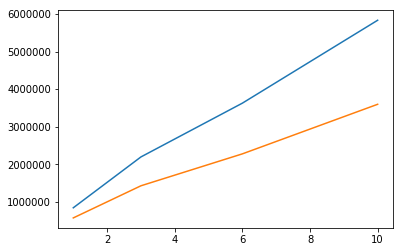

display of the relative space taken by document by the inverted file
in function of the number of documents injected in


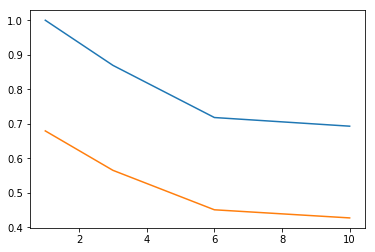

In [8]:
# absolute space taken
space_taken_naive = np.asarray(space_taken_naive)
space_taken_smart = np.asarray(space_taken_smart)

# relative space taken by document
relative_unique_doc_space_naive = space_taken_naive / number_of_docs
value_of_ref = relative_unique_doc_space_naive[0]
relative_unique_doc_space_naive /= value_of_ref
relative_unique_doc_space_smart = space_taken_smart / number_of_docs
relative_unique_doc_space_smart /= value_of_ref

print('display of the absolute space taken by the inverted file\n' +
      'in function of the number of documents injected in')
plt.plot(number_of_docs, space_taken_naive)
plt.plot(number_of_docs, space_taken_smart)
plt.show()

print('display of the relative space taken by document by the inverted file\n' +
      'in function of the number of documents injected in')
plt.plot(number_of_docs, relative_unique_doc_space_naive)
plt.plot(number_of_docs, relative_unique_doc_space_smart)
plt.show()

## Time to read a posting list

In [11]:
time_taken_naive = []
time_taken_smart = []
for n in number_of_docs:
    cur_time_naive = time_to_read_posting_list(n, 50, ndi)
    cur_time_smart = time_to_read_posting_list(n, 50, sdi)
    print(cur_time_naive)
    print(cur_time_smart)
    time_taken_naive.append(cur_time_naive)
    time_taken_smart.append(cur_time_smart)

Successfully parsed document <../latimes/la123189>
[nltk_data] Downloading package punkt to /home/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Successfully parsed document <../latimes/la123189>
[nltk_data] Downloading package punkt to /home/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0.0332276
0.04129804
Successfully parsed document <../latimes/la123189>
Successfully parsed document <../latimes/la102989>
Successfully parsed document <../latimes/la081889>
[nltk_data] Downloading package punkt to /home/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Successfully parsed document <../latimes/la123189>
Successfully parsed document <../latimes/la102989>
Successfully parsed do

## Observation

Between one and 10 documents saved, the weight of a document is approximately halved. Then it remains stable. The growth of the file size is linear in function of the number of documents  

display of the time taken to read a posting list
in function of the number of documents injected in


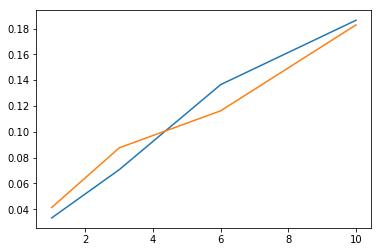

In [13]:
print('display of the time taken to read a posting list\n' +
      'in function of the number of documents injected in')
naive = plt.plot(number_of_docs, time_taken_naive)
smart = plt.plot(number_of_docs, time_taken_smart)
plt.show()